# Grab AI Challenge - Demand Forecasting

A data science assignment to predict demand forward so that Grab is able to improve traffic congenstion for Southeast Asia's road

## Data Ingestion

In order to perform the assignment, the data was provided by Grab in a csv format, this section seeks to ingest and explore the data attributes before applying modelling techniques on it.

In [1]:
!wget https://s3-ap-southeast-1.amazonaws.com/grab-aiforsea-dataset/traffic-management.zip
!unzip traffic-management.zip
!mv 'Traffic Management' trafficDemandData

--2019-06-16 14:31:48--  https://s3-ap-southeast-1.amazonaws.com/grab-aiforsea-dataset/traffic-management.zip
Resolving s3-ap-southeast-1.amazonaws.com (s3-ap-southeast-1.amazonaws.com)... 52.219.40.242
Connecting to s3-ap-southeast-1.amazonaws.com (s3-ap-southeast-1.amazonaws.com)|52.219.40.242|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 62874232 (60M) [application/zip]
Saving to: ‘traffic-management.zip.1’

traffic-management. 100%[===================>]  59.96M  94.3MB/s    in 0.6s    

2019-06-16 14:31:49 (94.3 MB/s) - ‘traffic-management.zip.1’ saved [62874232/62874232]

Archive:  traffic-management.zip
  inflating: Traffic Management/training.csv  


In [2]:
##Ingest data

import pandas as pd 
data = pd.read_csv("trafficDemandData/training.csv") 
data.head(5)

,geohash6,day,timestamp,demand
0,qp03wc,18,20:0,0.020072
1,qp03pn,10,14:30,0.024721
2,qp09sw,9,6:15,0.102821
3,qp0991,32,5:0,0.088755
4,qp090q,15,4:0,0.074468


In [3]:
##Description of data
display(data.describe(include='all'))
maxD=data['day'].max()
minD=data['day'].min()
print("Max day: {}, Min day: {}, day range: {}".format(maxD,minD,maxD-minD))

print("DataType of columns")
print(data.dtypes)

,geohash6,day,timestamp,demand
count,4206321,4.206321e+06,4206321,4.206321e+06
unique,1329,NaN,96,NaN
top,qp03wz,NaN,9:0,NaN
freq,5846,NaN,57281,NaN
mean,NaN,3.145299e+01,NaN,1.050907e-01
std,NaN,1.768278e+01,NaN,1.592655e-01
min,NaN,1.000000e+00,NaN,3.092217e-09
25%,NaN,1.600000e+01,NaN,1.867379e-02
50%,NaN,3.200000e+01,NaN,5.043463e-02
75%,NaN,4.700000e+01,NaN,1.208644e-01


Max day: 61, Min day: 1, day range: 60
DataType of columns
geohash6      object
day            int64
timestamp     object
demand       float64
dtype: object


In [4]:
##From timestamp column, we can see that we will need to do some processing on time
##Formula used for conversion x split by ":", hours multiply by 60 and add with mins, 
##this gives us a timestamp based off minutes and allow us to work with models where the timing is not correctly sequential
data['timestampInt']=data['timestamp'].map(lambda x:int((x.split(':'))[0])*60+int((x.split(':'))[1]))
data['timestampInt']=data['timestampInt'].map(lambda x:x/15)

|Cols|Description|
|----|-----|
|geohash6|5846 unique locations|
|timestamp|96 15mins time interval|
|day| 61 days|

Given the dataset, the segregation should be achieved by possibly grouping geography together followed by prediction of the demand in the specified timespace (day+timestamp). Thinking out now, this is to allow a margin of error for spillover since nearby location is expected to share the same demand.

This allows pooling of resources and building up a beefier prediction model since given a geohash,day and timestamp, it will only have 1 demand point. That can skew results with the sparse data.

To tackle this issue, an unsupervised geospatial model is required to allow translation of the hash into a particular geographic group


In [5]:
##Decode hash data into geospatial data for unsupervised learning
##Geohash is good approximation way to cluster, not going for unsupervised learning, this is due to the hardware requirement to 
#conduct a hdbscan
import Geohash
data['geohash6_decoded']=data['geohash6'].map(Geohash.decode)
data['geohash6_decoded'].head(5)

0    (-5.35308837890625, 90.6536865234375)
1    (-5.41351318359375, 90.6646728515625)
2    (-5.32562255859375, 90.9063720703125)
3    (-5.35308837890625, 90.7525634765625)
4    (-5.41351318359375, 90.7196044921875)
Name: geohash6_decoded, dtype: object

In [6]:
##Splitting the data into 2 dimensional arrays for easy handling
data['lat']=data['geohash6_decoded'].map(lambda a:round(a[0],6))
data['long']=data['geohash6_decoded'].map(lambda a:round(a[1],6))

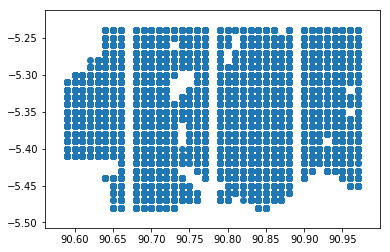

In [23]:
##plot coordinates to have a visual interpretation
from matplotlib import pyplot as plt
plt.scatter(data['long'],data['lat'])
plt.show()

### Initial Intentions

From the data we can see that there is no obvious cluster and there are 5846 unique spot.
<br>From the plot we can see a pattern as well except that data is in a pretty grid
<br>To reduce the number of unique groups to work with, it is recommended to work with HDBscan to form geographic density clusters

However, this unsupervised learning methodology is extremely taxing for a consumer grade system and is unable to complete.
Hence in the interest of completion, this is omitted.

>**Deprecated Code**
><br>import hdbscan
><br>rad= np.radians(data[['long','lat']].values)
><br>#haversine is a distance measure for coordinates
><br>clust = hdbscan.HDBSCAN(min_cluster_size=2, metric = 'haversine')
><br>pred = clust.fit_predict(rad)
><br>##fitting of cluster to allow reduce unique groups

There was also the intention to use kMeans to cluster the data so that it will be easier to train, however given that geohashing is already so good approximation of location in a grid, this step was ultimately dropped.

### Finalised Intentions
With the understanding that geohash6 is a good form of geographical cluster within a grid, the decision was to have a model for each region. This is computationally heavy and on hindsight, the code should have been written for parallel processing.

From the graph below, we try to visualise how a region series/model will look like

The first graph is the demand plot for a specified region overlayed by its various date variation

The later graph is the demand plot osciliation across time from the start to the end, showing that there is a known trend that can be modelled.

GeoHash: qp03wf


/home/limguanyu_08_gmail_com/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


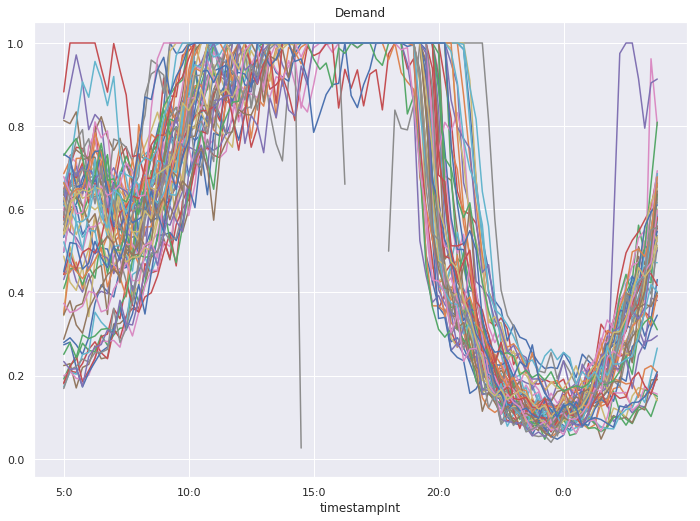

GeoHash: qp09cd


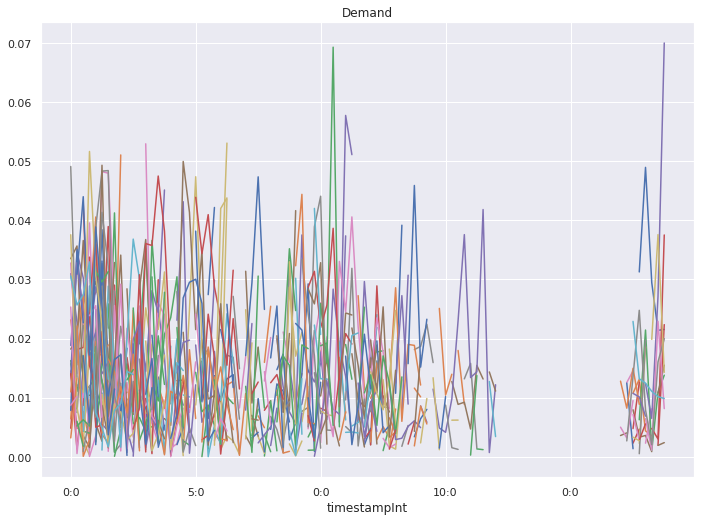

In [8]:
'''Should there be a need to perform time series forecasting on each geographic point ?
This reduce computational need while allowing accuracy ignoring spill over effect'''
def plotDemand(data,geolocation=None):
    import random
    geoChoice = random.choice(data.geohash6)
    if geolocation != None:
        geoChoice = geolocation
    print("GeoHash: {}".format(geoChoice))
    oneRegionData = data[data.geohash6 == geoChoice]
    oneRegionData.sort_values(by=['day','timestampInt'],inplace=True)
    import seaborn as sns
    from matplotlib import pyplot
    sns.set()
    ax=oneRegionData.reset_index().pivot('timestampInt','day','demand').plot(title='Demand', \
    grid=True,figsize=(11.7,8.37),legend=False)
    ax.set_xticklabels(oneRegionData.reset_index()['timestamp'].loc[oneRegionData.reset_index()['timestampInt'].isin([0,20,40,60,80])]);
    pyplot.show()
    return

plotDemand(data, geolocation="qp03wf")
#Shows that the cynlical demand within a day, 
#rises at the start, peak during work hours, desc after 8pm to reach a plateau at midnight

plotDemand(data)

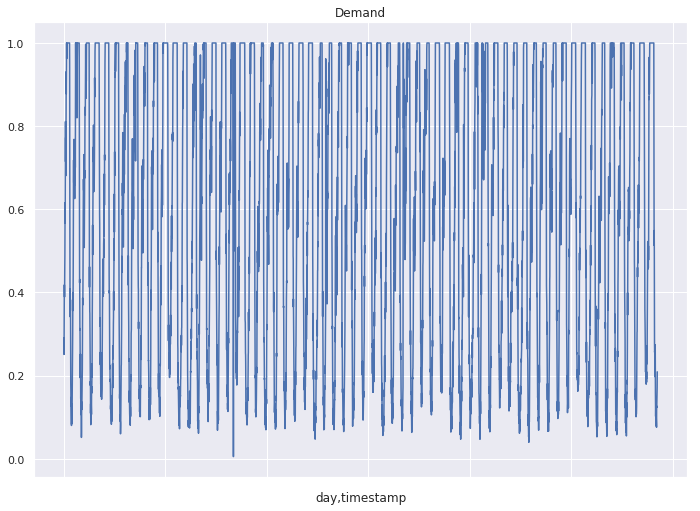

In [25]:
oneRegionData['demand'].plot(title='Demand', grid=True,figsize=(11.7,8.37),legend=False)
#Day by day the demand oscillates between 0.1 to 1 and it seems to be the same across everyday.
#Hence it is more important to be able to identify the point in time and the demand it follows from

## Problem Formulation

In this challenge, the model is required to forecast ahead by T+1 to T+5 time intervals when data is provided up to time T

Up to 14 days up to T can used used tp predict this interval.

Given the nature of this problem, an LSTM model can be used to predict on each geohash coverage. This is computationally exhuastive but ideal to keep the demand fixed to a small geo location, reducing potential errors.

Given the choice of the model, the most critical issue here is to automate the feature engineering process for the data set that will be provided.

The following code attempt to break the preprocessing into various function and finally tying them together during the model evaluation step

In [44]:
def prepData(data,geolocation=None,lags=4):
    ##Code was written to use lag 4 due to vector of 5 map to vector of 5 (based of the problem)
    import random
    import numpy as np
    geoChoice = random.choice(data.geohash6)
    if geolocation != None:
        geoChoice = geolocation
    print("GeoHash: {}".format(geoChoice))
    oneRegionData = data[data.geohash6 == geoChoice]
    oneRegionData.sort_values(by=['day','timestampInt'],inplace=True,ascending=False)
    for l in range(1,lags+1):
        oneRegionData['demandLagTermT_'+str(l)] = oneRegionData['demand'].shift(-l)
        oneRegionData['timestampIntLagTermT_'+str(l)] = oneRegionData['timestampInt'].shift(-l)
    #range forward is fixed as we are predicting forward    
    for l in range(1,6):
        oneRegionData['demandForwardTermT_'+str(l)] = oneRegionData['demand'].shift(l)
    oneRegionData=oneRegionData.dropna()
    oneRegionData=oneRegionData.drop(['day','geohash6','timestamp'], axis=1)
    
    forwardData = [f for f in oneRegionData.axes[1] if "ForwardTerm" in f]
    demandLagData = [l for l in oneRegionData.axes[1] if "demandLagTerm" in l]
    timestampIntLagData = [l for l in oneRegionData.axes[1] if "timestampIntLagTerm" in l]
    
    forwardData = oneRegionData[forwardData]
    demandLagData = oneRegionData[['demand']+demandLagData]
    timestampIntLagData = oneRegionData[['timestampInt']+timestampIntLagData]
    
    X=np.hstack((demandLagData[::-1].values,timestampIntLagData[::-1].values))
    X=np.reshape(X,(X.shape[0],int(X.shape[1]/2),2))
    
    y=forwardData[::-1].values
    y=y.reshape((y.shape[0],y.shape[1],1))
    
    return y,X

In [46]:
def splitData(X,y):
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X,y,shuffle=False)
    return X_train, X_test, y_train, y_test

In [14]:
def evaluateTrainingModel(model,X_test,y_test):
    from sklearn.metrics import mean_squared_error
    y_hat=model.predict(X_test)
    y_test=y_hat.reshape(y_test.shape[0],y_test.shape[1])
    y_hat=y_hat.reshape(y_hat.shape[0],y_hat.shape[1])
    return mean_squared_error(y_test, y_hat)

In [11]:
def modelData(X,y,geolocation,verbose=0,epochs=2,batch_size=32):
    from keras.models import Sequential
    from keras.layers import Dense,LSTM,Flatten
    from keras.layers import RepeatVector,Dropout,TimeDistributed
    from keras.callbacks import ModelCheckpoint, EarlyStopping
    X_train, X_test, y_train, y_test = splitData(X,y)
    modelPath = "models/"+geolocation+".hdf5"
    checkpointer = ModelCheckpoint(modelPath, verbose=0, save_weights_only=True)
    earlyStop= EarlyStopping(monitor='loss', mode='min')
    model = Sequential()
    model.add(LSTM(200, activation='relu',input_shape=X.shape[-2:],return_sequences=True))
    model.add(LSTM(200, activation='relu',return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(Dropout(0.2))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    print(model.summary())
    model.fit(X_train,y_train,epochs=epochs,batch_size=batch_size,verbose=verbose,callbacks=[checkpointer,earlyStop])
    res=evaluateTrainingModel(model,X_test,y_test)
    return res
    

## Model Training
The for loop here will iterate through all the distinct region to create a model for each, early stopping is used to reduce training time for each model forgiving accurarcy. Should parallelisation be used, this would not be an issue. To reduce memory overhead, the model weights are saved to disk.

In [15]:
'''Code to orgnaise everything to create model for all geographical region and save down'''
import os 
for geolocation in list(set(data['geohash6'].values)):
    print("INFO: Training Model for Geohash {}".format(geolocation))
    modelPath = "models/"+geolocation+".hdf5"
    if os.path.isfile(modelPath):
        print ("INFO: Existing Model Present, Skipping {}".format(geolocation))
    else:
        y,X=prepData(data,geolocation=geolocation,lags=4)
        try:
            print("INFO: MSE Result: {}".format(modelData(X,y,geolocation)))
        except Exception as e:
            print("ERROR: {}".format(e))
            print("WARNING: Skipping {}".format(geolocation))
        
    

INFO: Training Model for Geohash qp099m
INFO: Existing Model Present, Skipping qp099m
INFO: Training Model for Geohash qp09vg
INFO: Existing Model Present, Skipping qp09vg
INFO: Training Model for Geohash qp0dhc
INFO: Existing Model Present, Skipping qp0dhc
INFO: Training Model for Geohash qp09mr
INFO: Existing Model Present, Skipping qp09mr
INFO: Training Model for Geohash qp08be
INFO: Existing Model Present, Skipping qp08be
INFO: Training Model for Geohash qp02z7
INFO: Existing Model Present, Skipping qp02z7
INFO: Training Model for Geohash qp09gx
INFO: Existing Model Present, Skipping qp09gx
INFO: Training Model for Geohash qp03yc
INFO: Existing Model Present, Skipping qp03yc
INFO: Training Model for Geohash qp09d3
INFO: Existing Model Present, Skipping qp09d3
INFO: Training Model for Geohash qp03z8
INFO: Existing Model Present, Skipping qp03z8
INFO: Training Model for Geohash qp08ck
INFO: Existing Model Present, Skipping qp08ck
INFO: Training Model for Geohash qp09gj
INFO: Existing

/home/limguanyu_08_gmail_com/GrabChallenge/grab.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  oneRegionData.sort_values(by=['day','timestampInt'],inplace=True,ascending=False)
/home/limguanyu_08_gmail_com/GrabChallenge/grab.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  oneRegionData['demandLagTermT_'+str(l)] = oneRegionData['demand'].shift(-l)
/home/limguanyu_08_gmail_com/GrabChallenge/grab.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_27 (LSTM)               (None, 5, 200)            162400    
_________________________________________________________________
lstm_28 (LSTM)               (None, 5, 200)            320800    
_________________________________________________________________
time_distributed_27 (TimeDis (None, 5, 100)            20100     
_________________________________________________________________
dropout_14 (Dropout)         (None, 5, 100)            0         
_________________________________________________________________
time_distributed_28 (TimeDis (None, 5, 1)              101       
Total params: 503,401
Trainable params: 503,401
Non-trainable params: 0
_________________________________________________________________
None
INFO: MSE Result: 0.0
INFO: Training Model for Geohash qp08bu
GeoHash: qp08bu


KeyboardInterrupt: 

In [41]:
def trainAllModel(csvFile="trafficDemandData/training.csv"):
    '''
    Wrapper to simplify training
    '''
    import pandas as pd 
    data = pd.read_csv(csvFile)
    data['timestampInt']=data['timestamp'].map(lambda x:int((x.split(':'))[0])*60+int((x.split(':'))[1]))
    data['timestampInt']=data['timestampInt'].map(lambda x:x/15)
    import os 
    for geolocation in list(set(data['geohash6'].values)):
        print("INFO: Training Model for Geohash {}".format(geolocation))
        modelPath = "models/"+geolocation+".hdf5"
        if os.path.isfile(modelPath):
            print ("INFO: Existing Model Present, Skipping {}".format(geolocation))
        else:
            y,X=prepData(data,geolocation=geolocation,lags=4)
            try:
                print("INFO: MSE Result: {}".format(modelData(X,y,geolocation)))
            except Exception as e:
                print("ERROR: {}".format(e))
                print("WARNING: Skipping {}".format(geolocation))

## Model Evaluation

Note that the models weights are not provided due to size limit on github, the code provided are expected to train the model weights.
In the interest of time against accuracy, speed was the main driver behind the model trianing to allow an early exit when losses are not improving, with better patience we should get better model but this is a balance when it was chosen to train one model for each geographical location.

The code below made the following assumptions:
1. The models have already been trained and saved to disk under models/{geographicalRegion}
2. The holdout data input has a schema which is the same as the training data csv
3. However the data will only involve the 14 days of hold out data to predict forward, Y is not provided
4. All geographical region holdout data will be in the holdout data input

In [38]:
'''
Pipeline Code to automate testing
Ingest test data set
Create feature set that has 5 5 
Load related model
Predict forward
Score against y
save score to global 
Return list of score [0.10,0.012,0.3]
'''

def ingestHoldOutData(csvFile):
    import pandas as pd 
    import numpy as np
    data = pd.read_csv(csvFile) 
    data['timestampInt']=data['timestamp'].map(lambda x:int((x.split(':'))[0])*60+int((x.split(':'))[1]))
    data['timestampInt']=data['timestampInt'].map(lambda x:x/15)
    data.sort_values(by=['geohash6','day','timestampInt'],inplace=True,ascending=False)
    return data

def createTestFeature(data, lags=4):
    for l in range(1,lags+1):
        data['demandLagTermT_'+str(l)] = data['demand'].shift(-l)
        data['timestampIntLagTermT_'+str(l)] = data['timestampInt'].shift(-l)
    data=data.dropna()
    data=data.drop(['day','geohash6','timestamp'],axis=1)
    demandLagData = [l for l in data.axes[1] if "demandLagTerm" in l]
    timestampIntLagData = [l for l in data.axes[1] if "timestampIntLagTerm" in l]
    demandLagData = data[['demand']+demandLagData]
    timestampIntLagData = data[['timestampInt']+timestampIntLagData]
        
    X=np.hstack((demandLagData[::-1].values,timestampIntLagData[::-1].values))
    X=np.reshape(X,(X.shape[0],int(X.shape[1]/2),2))
    return X[-1]

def createModel(X):
    from keras.models import Sequential
    from keras.layers import Dense,LSTM,Flatten
    from keras.layers import Dropout,TimeDistributed
    model = Sequential()
    model.add(LSTM(200, activation='relu',input_shape=X.shape[-2:],return_sequences=True))
    model.add(LSTM(200, activation='relu',return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(Dropout(0.2))
    model.add(TimeDistributed(Dense(1)))
    return model

def evaluateModel(model,X_test,y_test):
    from sklearn.metrics import mean_squared_error
    y_hat=model.predict(X_test)
    y_hat=y_hat.reshape(y_hat.shape[1])
    return mean_squared_error(y_test, y_hat)

def testModel(csvFile,y):
    '''given input data, loop through each distinct region
    Requirement: y must be available as an object with key-value pair of {region:t+1,t+2,t+3,t+4,T+5}, similar to X
    Loop through keys to read models and evaluate.
    save mse to global
    '''
    import os
    assert (type(y)==dict), "y is required to a be a key-value pair with {region:[t+1,t+2,t+3,t+4,t+5]}"
    res=[]
    data=ingestHoldOutData(csvFile)
    for geolocation in list(set(data['geohash6'].values)):
        X=createTestFeature(data[data.geohash6==geolocation])
        modelPath = "models/"+geolocation+".hdf5"
        if os.path.isfile(modelPath):
            print ("INFO: Importing {} Model for prediction".format(geolocation))
        else:
            raise Exception("{} model wight not found, please re-run training of weights".format(geolocation))
        X=X.reshape(1,X.shape[0],X.shape[1])
        model = createModel(X)
        model.load_weights(modelPath)
        res.append(evaluateModel(model,X,y[geolocation]))
    return res
        
    
    
    

## Main Evaluation Function

This evaluation function is created to simplify the pipeline to evaluate the created model
Model Training Code must be carried out in order for existing model to be present

Discussion is ommitted as the model is required to be trained but due to lack of computational processing, not all models can be trained quickly but from the MSE of the models produced, the results are pretty decent to not warrant further validation changes

In [7]:
!wget https://s3-ap-southeast-1.amazonaws.com/grab-aiforsea-dataset/traffic-management.zip
!unzip traffic-management.zip
!mv Traffic\ Management/training.csv trafficDemandData/.

--2019-06-16 14:39:22--  https://s3-ap-southeast-1.amazonaws.com/grab-aiforsea-dataset/traffic-management.zip
Resolving s3-ap-southeast-1.amazonaws.com (s3-ap-southeast-1.amazonaws.com)... 52.219.36.162
Connecting to s3-ap-southeast-1.amazonaws.com (s3-ap-southeast-1.amazonaws.com)|52.219.36.162|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 62874232 (60M) [application/zip]
Saving to: ‘traffic-management.zip’

traffic-management. 100%[===================>]  59.96M  97.6MB/s    in 0.6s    

2019-06-16 14:39:22 (97.6 MB/s) - ‘traffic-management.zip’ saved [62874232/62874232]

Archive:  traffic-management.zip
  inflating: Traffic Management/training.csv  


In [ ]:
from grab import * 
trainAllModel()

INFO: Training Model for Geohash qp06p4
INFO: Existing Model Present, Skipping qp06p4
INFO: Training Model for Geohash qp03xw
GeoHash: qp03xw


/home/limguanyu_08_gmail_com/grab-demandforecast/grab.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  oneRegionData.sort_values(by=['day','timestampInt'],inplace=True,ascending=False)
/home/limguanyu_08_gmail_com/grab-demandforecast/grab.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  oneRegionData['demandLagTermT_'+str(l)] = oneRegionData['demand'].shift(-l)
/home/limguanyu_08_gmail_com/grab-demandforecast/grab.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 5, 200)            162400    
_________________________________________________________________
lstm_4 (LSTM)                (None, 5, 200)            320800    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 5, 100)            20100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 100)            0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 5, 1)              101       
Total params: 503,401
Trainable params: 503,401
Non-trainable params: 0
_________________________________________________________________
None
INFO: MSE Result: 0.0
INFO: Training Model for Geohash qp09gt
GeoHash: qp09gt
_____________________________________________________

In [1]:
'''
To use test function, input holdOutTestData with the same format as training input data
Function will ingest the data and sort it by geolocation followed by feature creation
With feature creation the last vector (assumption is that data is provided up to T) 
will be chosen to predict forward by 5 step
This vector will be compared against the key value pair of the correct demand
MSE error will be produced should the data is in the input

NOTE:
Error will be seen if the data is in the input data set but missing from the validation key value pair
'''

from grab import *
testModel('trafficDemandData/mockTest.csv',{'qp02yc':[0.01,0.02,0.03,0.04,0.05]})

INFO: Importing qp02yc Model for prediction


/home/limguanyu_08_gmail_com/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


[0.0002903456717677508]